# ROC_all

Generate receiver operating curves for ALL CNNs, PFNs, and BDTs.

Outputs are stored in `<data_dir>/model_outputs/<task_name>_pfn_test.npz`. Keys are `raw_outputs` and `y_true`.

In [1]:
import sys
sys.path.append("..")

from utils import data_dir

import numpy as np
from scipy.special import softmax

from tabulate import tabulate
import matplotlib.pyplot as plt

In [2]:
task_name = "axion1"

In [3]:
def compute_ROC(raw_outputs, y_true, working_points):
    """
    Inputs:
        - raw_outputs is an N x 3 array of final model outputs.
        - y_true is a list of ints with classes.
    Returns:
        - a list of coordinates (sig_eff, bkg_eff) to comprise a curve.
        - a list of (sig_eff, 1/bkg_eff) for given working points.
    """
    raw_probs = softmax(raw_outputs, axis=1)
    sig_probs = raw_probs[y_true == 2][:,2]
    bkg_probs = raw_probs[y_true < 2][:,2]
    
    def get_thresh(working_point, atol=1e-6):
        # Get threshold given working point using *binary search*!
        # Recall: working point is desired signal efficiency.
        lo = 0
        hi = 1
        while hi - lo > atol:
            mid = (lo + hi) / 2
            if np.mean(sig_probs > mid) > working_point:
                lo = mid
            else:
                hi = mid
        return (lo + hi) / 2

    # Broad curve
    dense_wps = np.linspace(0.95, 1, 200)
    curve = []
    for wp in dense_wps:
        thresh = get_thresh(wp)
        curve.append((np.mean(sig_probs > thresh), np.mean(bkg_probs > thresh)))

    # Specific points
    table = []
    for wp in working_points:
        thresh = get_thresh(wp)
        table.append((np.mean(sig_probs > thresh), 1 / np.mean(bkg_probs > thresh)))

    return np.array(curve), table

In [4]:
task2label = {
    "scalar1": r"$h_2\rightarrow\pi^0\pi^0$",
    "axion1": r"$a\rightarrow\gamma\gamma$",
    "axion2": r"$a\rightarrow3\pi^0$"
}

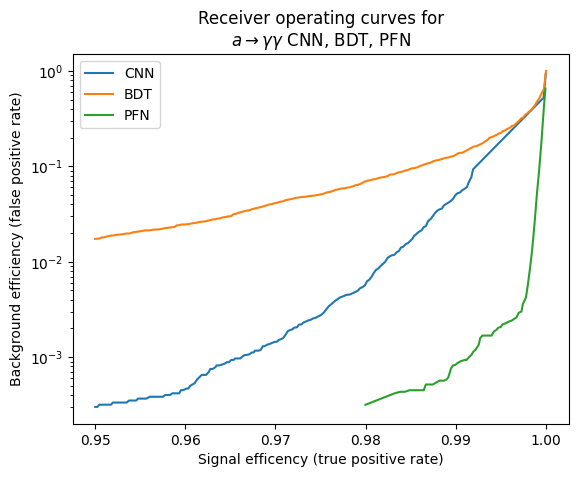

In [5]:
plt.yscale("log")
plt.xlabel("Signal efficency (true positive rate)")
plt.ylabel("Background efficiency (false positive rate)")

tables = {}
working_points = [0.9, 0.95, 0.99, 0.995]

for model in ["cnn", "bdt", "pfn"]:
    outputs = np.load(f"{data_dir}/model_outputs/{task_name}_{model}_test.npz")
    raw_outputs = outputs["raw_outputs"]
    y_true = outputs["y_true"]

    curve, table = compute_ROC(raw_outputs, y_true, working_points)
    tables[model] = table
    plt.plot(*curve.T, label=model.upper())

plt.title(f"Receiver operating curves for\n{task2label[task_name]} CNN, BDT, PFN")
plt.legend()

In [6]:
# Formatting working points for the table
wp_format = {
    0.9: "90%",
    0.95: "95%",
    0.99: "99%",
    0.995: "99.5%",
}

header = ["Model"] + [f"{task2label[task_name]}\n{wp_format[wp]} rej. rate" for wp in working_points]
table = []
for model, rej_rates in tables.items():
    row = [model.upper()] + [round(rr) for _, rr in rej_rates]
    table.append(row)

print(tabulate(table, headers=header))

Model      $a\rightarrow\gamma\gamma$    $a\rightarrow\gamma\gamma$    $a\rightarrow\gamma\gamma$    $a\rightarrow\gamma\gamma$
                        90% rej. rate                 95% rej. rate                 99% rej. rate               99.5% rej. rate
-------  ----------------------------  ----------------------------  ----------------------------  ----------------------------
CNN                             19944                          3324                            20                            11
BDT                               188                            58                             7                             4
PFN                              3157                          3157                          1200                           484
